In [1]:
import pandas as pd
import numpy as np
from joblib import load

cdfs = load('Data/composer_dfs')
cdfs

,0,1,2,key_presses,merged
0,Data/ChopinKeyboard/Chop-28-8.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...,15 16 17 18 19 20 21 22 23 2...
1,Data/ChopinKeyboard/Chop-28-23.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...,15 16 17 18 19 20 21 22 23 2...
2,Data/ChopinKeyboard/Chop-28-22.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...,15 16 17 18 19 20 21 22 23 2...
3,Data/ChopinKeyboard/10-02-i.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...,15 16 17 18 19 20 21 22 23 2...
4,Data/ChopinKeyboard/Chop-28-9.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...,15 16 17 18 19 20 21 22 23 2...
...,...,...,...,...,...
5,Data/RachmaninoffKeyboard/rach-prelude23-02.mid,channel note velocity time note_type ...,rachmaninoff,channel note velocity time note_type ...,15 16 17 18 19 20 21 22 23 2...
6,Data/RachmaninoffKeyboard/rach-prelude23-01.mid,channel note velocity time note_type ...,rachmaninoff,channel note velocity time note_type ...,15 16 17 18 19 20 21 22 23 2...
7,Data/RachmaninoffKeyboard/rach-prelude-op3-no2...,channel note velocity time note_type ...,rachmaninoff,channel note velocity time note_type ...,15 16 17 18 19 20 21 22 23 2...
8,Data/RachmaninoffKeyboard/rach-prelude23-09.mid,channel note velocity time note_type ...,rachmaninoff,channel note velocity time note_type ...,15 16 17 18 19 20 21 22 23 2...


In [2]:
#need to have the same # of notes in each training sample for LSTMs
#choose 50 arbitrarily

def fast_chunk(piece, n_notes = 30, overlapping = False, overlap_steps = 1, merge = True):
    chunks = []
    if merge:
        p = piece.merged.drop(columns = ['note_type'])
    else:
        p = piece.keys_pressed.drop(columns=['note_type'])
    if not overlapping:
        chop_off = len(p) % n_notes
        n_splits = len(p) / n_notes
        if chop_off > 0:
            chunks.extend(np.split(p[:-chop_off],int(n_splits)))
        else:
            chunks.extend(np.split(p,int(n_splits)))
    else:
        for i in range(n_notes//overlap_steps):
            chop_off = len(p) % n_notes
            n_splits = len(p) // n_notes
            if chop_off == len(p):
                pass
            elif chop_off > 0:
                chunks.extend(np.split(p[:-chop_off],n_splits))
            else:
                chunks.extend(np.split(p,n_splits))
            p = p.iloc[overlap_steps:]
    return pd.DataFrame({'data':chunks,'filename':piece[0],'Composer':piece[2]})

from joblib import Parallel, delayed
from tqdm import tqdm

def chunk_all(all_pieces, n_notes = 50, overlap_steps = 5):
    p = Parallel(n_jobs=1)
    del_f = delayed(fast_chunk)
    return pd.concat(p(del_f(piece, n_notes, True, overlap_steps) for i, piece in tqdm(all_pieces.iterrows(), position = 0, leave = True)))

In [3]:
n_notes = 50

compositions = chunk_all(cdfs,n_notes = n_notes,overlap_steps=25)
compositions

389it [00:02, 152.17it/s]


,data,filename,Composer
0,15 16 17 18 19 20 21 22 23 2...,Data/ChopinKeyboard/Chop-28-8.mid,chopin
1,15 16 17 18 19 20 21 22 23 2...,Data/ChopinKeyboard/Chop-28-8.mid,chopin
2,15 16 17 18 19 20 21 22 23 2...,Data/ChopinKeyboard/Chop-28-8.mid,chopin
3,15 16 17 18 19 20 21 22 23 2...,Data/ChopinKeyboard/Chop-28-8.mid,chopin
4,15 16 17 18 19 20 21 22 23 2...,Data/ChopinKeyboard/Chop-28-8.mid,chopin
...,...,...,...
62,15 16 17 18 19 20 21 22 23 2...,Data/RachmaninoffKeyboard/rach-prelude23-08.mid,rachmaninoff
63,15 16 17 18 19 20 21 22 23 2...,Data/RachmaninoffKeyboard/rach-prelude23-08.mid,rachmaninoff
64,15 16 17 18 19 20 21 22 23 2...,Data/RachmaninoffKeyboard/rach-prelude23-08.mid,rachmaninoff
65,15 16 17 18 19 20 21 22 23 2...,Data/RachmaninoffKeyboard/rach-prelude23-08.mid,rachmaninoff


In [4]:
#select composers
# selected = compositions.Composer.value_counts()
# selected = selected / selected.sum()
# selected = selected[selected > 0].index
selected = ['chopin','bach','mozart']
compositions = compositions[compositions.Composer.isin(selected)]

In [5]:
compositions.Composer.value_counts()

bach      2072
chopin    1487
mozart    1165
Name: Composer, dtype: int64

In [6]:
all_rows = pd.concat(compositions.data.values)
all_rows

,15,16,17,18,19,20,21,22,23,24,...,111,112,113,114,115,channel,velocity,time,cumtime,length
cumtime,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,90,0,0,288.0
48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,90,48,48,48.0
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,90,0,64,64.0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,90,0,96,48.0
128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,90,0,128,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,90,0,111264,96.0
111360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,90,0,111360,192.0
111456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,90,0,111456,96.0


In [8]:
from sklearn.preprocessing import MinMaxScaler

#get the one hot encoded note values for later concatenation with the rest
one_hot_notes = all_rows[np.arange(15,116)]
#minmax scale the rest of the features
minmaxed = MinMaxScaler((0,1)).fit_transform(all_rows[['velocity','length','cumtime']])
minmaxed

array([[6.78260870e-01, 4.15279988e-02, 0.00000000e+00],
       [6.78260870e-01, 6.80075242e-03, 7.04820975e-05],
       [6.78260870e-01, 9.11590218e-03, 9.39761301e-05],
       ...,
       [6.78260870e-01, 1.37462017e-02, 1.63659431e-01],
       [6.78260870e-01, 2.76371003e-02, 1.63800395e-01],
       [6.78260870e-01, 1.37462017e-02, 1.63941359e-01]])

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

#one hot encode the channel values
#channel_onehot = tf.one_hot(all_rows.channel, depth = len(all_rows.channel.unique()))

X = tf.concat([minmaxed, one_hot_notes],axis=1)
#reshape X
xs = X.shape
X = tf.reshape(X, (xs[0]//n_notes,n_notes,xs[1]))

encoder = LabelEncoder()
y = encoder.fit_transform(compositions.Composer)
n_ys = len(np.unique(y))
print('Unique Composers: ',n_ys)

Unique Composers:  3


In [11]:
from sklearn.model_selection import train_test_split

#relabel and manually split the data so that the same piece's chunks don't get put into the same set
ready_dat = pd.DataFrame({'data':list(X.numpy()),
                          'Composer':y,
                          'filename':compositions.filename.values})

split_percentage = 0.6
test, train = [], []
#for each composer split their pieces into training and test sets
for comp in ready_dat.Composer.unique():
    comp_pieces = ready_dat[ready_dat.Composer == comp]
    piece_grouped = comp_pieces.groupby('filename').groups
    keys = list(piece_grouped.keys())
    np.random.shuffle(keys)
    split_point = int(len(keys)*split_percentage)
    trainkeys,testkeys = keys[:split_point],keys[split_point:]
    for k in trainkeys:
        train.extend(piece_grouped[k])
    for k in testkeys:
        test.extend(piece_grouped[k])
test, train = ready_dat.loc[test], ready_dat.loc[train]

#get the number of features in the data
n_features = train.data.iloc[0].shape[1]

#takes in the data column of the train or test set
def to_tf_x(xset):
    return tf.constant(np.concatenate(xset.values).reshape(len(xset),n_notes,n_features))

#takes in the composer column of the train/test set
def to_tf_y(yset):
    return tf.one_hot(yset.values,n_ys)

X_train, X_test = to_tf_x(train.data), to_tf_x(test.data)
y_train, y_test = to_tf_y(train.Composer), to_tf_y(test.Composer)

In [12]:
from sklearn.utils import class_weight

u_ys = np.unique(y)
cweights = class_weight.compute_class_weight(class_weight=None, classes = u_ys, y = train.Composer)
cweight_dict = {}
for i in range(n_ys):
    cweight_dict[u_ys[i]] = cweights[i]

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import random

random.seed(5)

model = Sequential()
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(16))
model.add(Dense(n_ys, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, 
                    epochs = 10, 
                    batch_size = 64, 
                    class_weight = cweight_dict)
print(model.summary())

Epoch 1/10
51/51 [==============================] - 5s 43ms/step - loss: 0.9572 - accuracy: 0.5086
Epoch 2/10
51/51 [==============================] - 2s 40ms/step - loss: 0.6199 - accuracy: 0.7374
Epoch 3/10
51/51 [==============================] - 2s 39ms/step - loss: 0.5253 - accuracy: 0.7846
Epoch 4/10
51/51 [==============================] - 2s 39ms/step - loss: 0.5427 - accuracy: 0.7758
Epoch 5/10
51/51 [==============================] - 2s 39ms/step - loss: 0.4769 - accuracy: 0.8096
Epoch 6/10
51/51 [==============================] - 2s 39ms/step - loss: 0.4273 - accuracy: 0.8341
Epoch 7/10
51/51 [==============================] - 2s 39ms/step - loss: 0.4029 - accuracy: 0.8403
Epoch 8/10
51/51 [==============================] - 2s 39ms/step - loss: 0.3660 - accuracy: 0.8585
Epoch 9/10
51/51 [==============================] - 2s 41ms/step - loss: 0.3783 - accuracy: 0.8470
Epoch 10/10
51/51 [==============================] - 2s 39ms/step - loss: 0.3167 - accuracy: 0.8792
Model: "s

dict_keys(['loss', 'accuracy'])


<AxesSubplot:label='0da89a1c-c92c-4c7f-9e7e-ba88678db18c'>

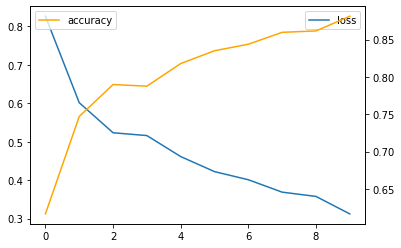

In [14]:
import seaborn as sns

print(history.history.keys())
l = history.history['loss']
a = history.history['accuracy']
epoch = np.arange(len(l))

ax = sns.lineplot(x = epoch, y = l, label = 'loss')
ax2 = ax.twinx()
sns.lineplot(x = epoch, y = a, label = 'accuracy', ax = ax2, color = 'orange')

acc:  0.6305062458908612


<AxesSubplot:>

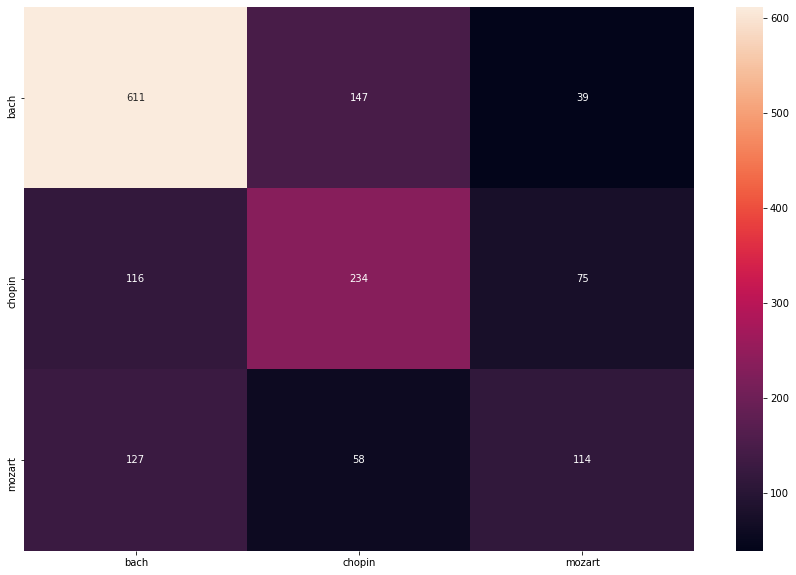

In [15]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

pred = encoder.inverse_transform(np.argmax(model.predict(X_test),axis=1))
true = encoder.inverse_transform(np.argmax(y_test,axis=1))
labels = np.unique(pred)

print('acc: ',(true==pred).mean())
cf = confusion_matrix(true, pred)
plt.figure(figsize=(15,10))
sns.heatmap(cf, annot=True, fmt = '.5g',xticklabels = labels, yticklabels = labels)

In [16]:
#what about predictions on each piece?
test['name'] = encoder.inverse_transform(test.Composer)
test['pred'] = pred
test

,data,Composer,filename,name,pred
1188,"[[0.6782608695652175, 0.027637100274924033, 0....",1,Data/ChopinKeyboard/Chop-28-4.mid,chopin,chopin
1189,"[[0.6782608695652175, 0.027637100274924033, 0....",1,Data/ChopinKeyboard/Chop-28-4.mid,chopin,chopin
1190,"[[0.6782608695652175, 0.027637100274924033, 0....",1,Data/ChopinKeyboard/Chop-28-4.mid,chopin,chopin
1191,"[[0.6782608695652175, 0.027637100274924033, 0....",1,Data/ChopinKeyboard/Chop-28-4.mid,chopin,chopin
1192,"[[0.6782608695652175, 0.027637100274924033, 0....",1,Data/ChopinKeyboard/Chop-28-4.mid,chopin,chopin
...,...,...,...,...,...
3843,"[[1.0, 0.04152799884242512, 0.0284747674090780...",2,Data/MozartKeyboard/KV331_1_1_tema.mid,mozart,mozart
3844,"[[1.0, 0.013746201707422948, 0.041725401747956...",2,Data/MozartKeyboard/KV331_1_1_tema.mid,mozart,mozart
3845,"[[1.0, 0.013746201707422948, 0.008880744290950...",2,Data/MozartKeyboard/KV331_1_1_tema.mid,mozart,mozart
3846,"[[1.0, 0.013746201707422948, 0.022131378629828...",2,Data/MozartKeyboard/KV331_1_1_tema.mid,mozart,mozart


In [17]:
#take majority of each piece
predpiece = test[['name','pred','filename']].groupby('filename').agg(lambda x: pd.Series.mode(x)[0]).reset_index()
predpiece

,filename,name,pred
0,Data/BachKeyboard/AveMaria-PianoViolin.mid,bach,bach
1,Data/BachKeyboard/BWV-128.mid,bach,bach
2,Data/BachKeyboard/BWV-510.mid,bach,bach
3,Data/BachKeyboard/BWV-511.mid,bach,bach
4,Data/BachKeyboard/BWV-691.mid,bach,bach
...,...,...,...
78,Data/MozartKeyboard/k523.mid,mozart,bach
79,Data/MozartKeyboard/k574.mid,mozart,bach
80,Data/MozartKeyboard/menuet_k2.mid,mozart,bach
81,Data/MozartKeyboard/sonata1.mid,mozart,chopin


acc:  0.7469879518072289


<AxesSubplot:>

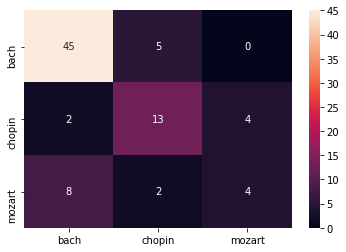

In [18]:
#confusion matrix
print('acc: ',(predpiece.name==predpiece.pred).mean())
cf_piece = confusion_matrix(predpiece.name, predpiece.pred)
sns.heatmap(cf_piece, annot=True, xticklabels = labels, yticklabels = labels)

In [19]:
#accuracy on each class
acc_per_class = (cf_piece/cf_piece.sum(axis=1)[:,np.newaxis]).diagonal()
dict(zip(labels, acc_per_class.round(2)))

{'bach': 0.9, 'chopin': 0.68, 'mozart': 0.29}